In [32]:
#Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

#Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

#System libraries
from pathlib import Path
import os.path

#Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [33]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [34]:
# ! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [35]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [36]:
# Walk through each directory
dataset = "classification_corals"
walk_through_dir(dataset)

There are 2 directories and 1 images in 'classification_corals'.
There are 0 directories and 485 images in 'classification_corals/bleached_corals'.
There are 0 directories and 438 images in 'classification_corals/healthy_corals'.


In [37]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [38]:
# Check for corrupted images within the dataset
import PIL
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

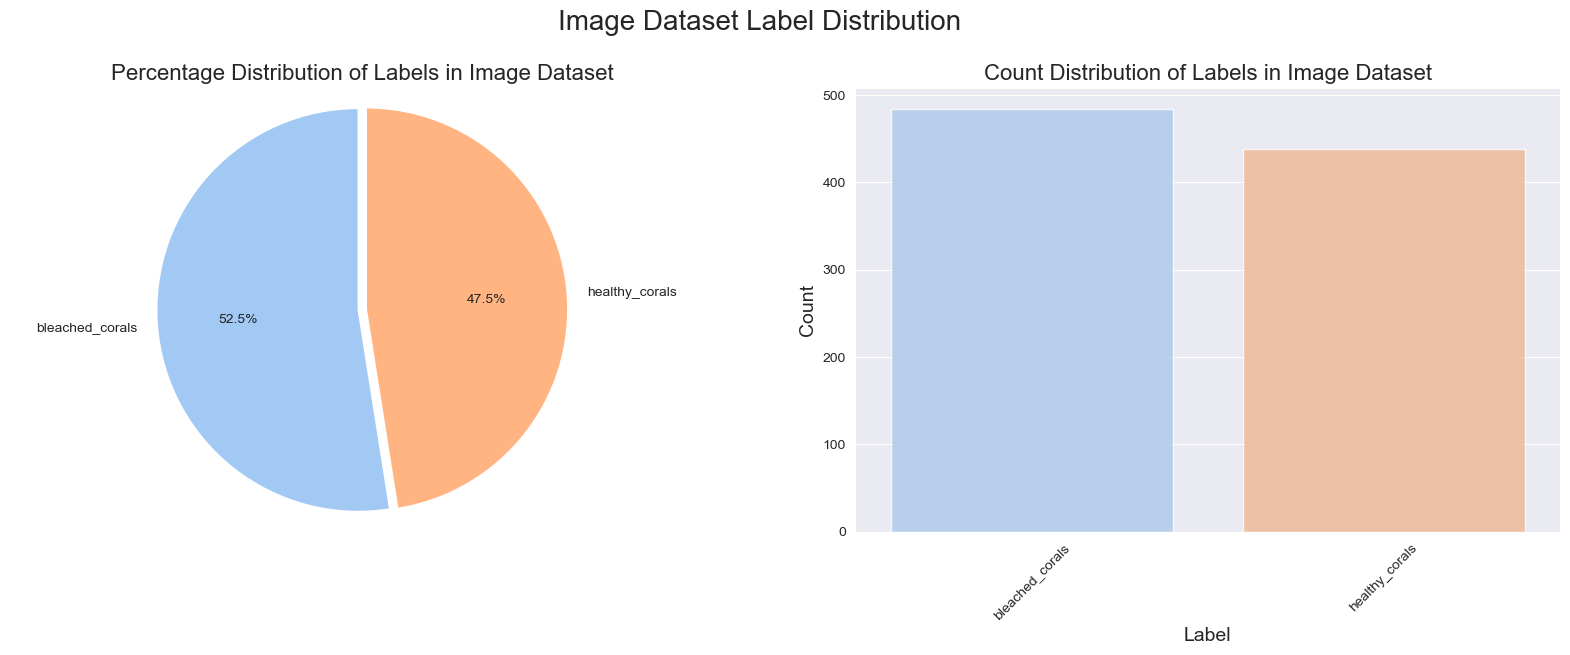

In [39]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Define the color palette for the pie chart
colors = sns.color_palette('pastel', len(label_counts))

# Plot the pie chart with percentages, colors, and separation
explode = [0.02] * len(label_counts)  # Define separation values for each pie slice
axes[0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie chart is circular
axes[0].set_title('Percentage Distribution of Labels in Image Dataset', fontsize=16)

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes[1])
axes[1].set_title('Count Distribution of Labels in Image Dataset', fontsize=16)
axes[1].set_xlabel('Label', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

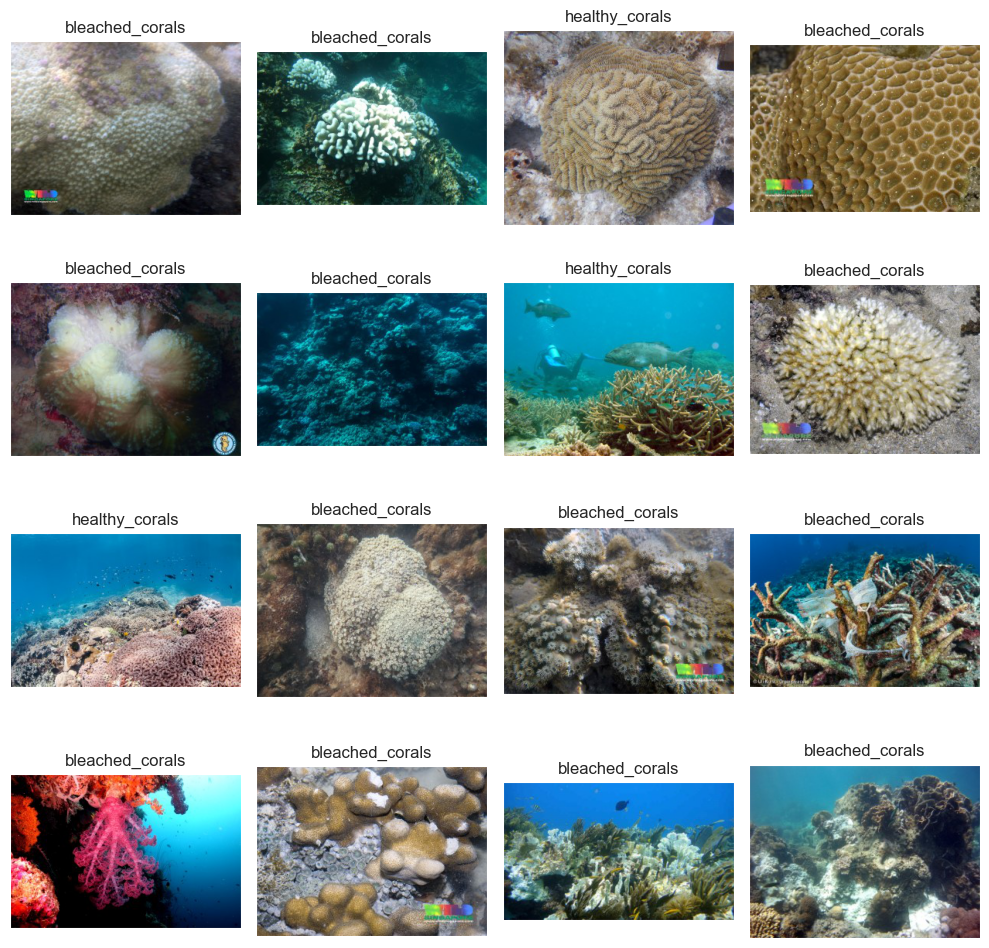

In [40]:
# Display 16 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [41]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

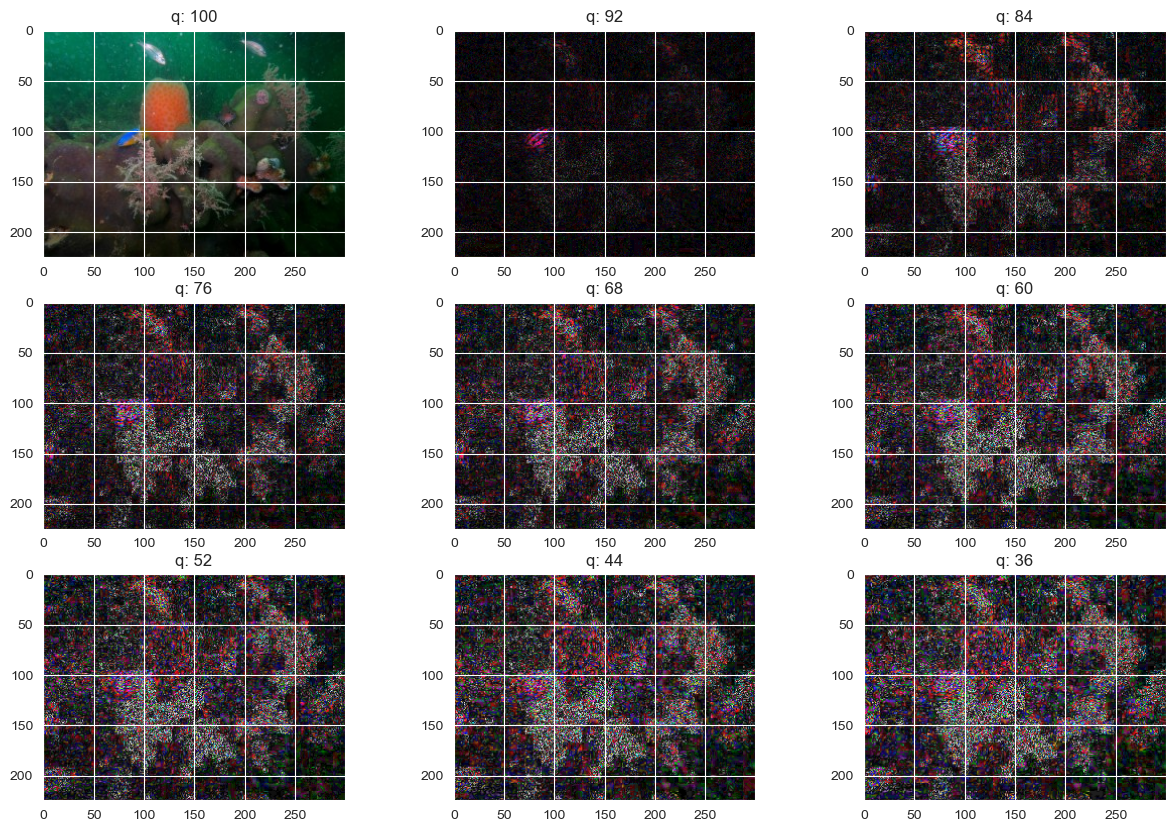

In [42]:
# View random sample from the dataset
p = random_sample('classification_corals/bleached_corals')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [43]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [52]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [53]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 590 validated image filenames belonging to 2 classes.
Found 147 validated image filenames belonging to 2 classes.
Found 185 validated image filenames belonging to 2 classes.


In [54]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [55]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [57]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "corals_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

NameError: name 'early_stopping' is not defined

In [22]:
# import numpy as np 
# import pandas as pd 
# import os
# from pathlib import Path

# import os.path
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import load_img,img_to_array
# print(tf.__version__)


# for dirname, _, filenames in os.walk('../machine_learning/classification_corals'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [23]:
# # Create a list with the filepaths for training and testing
# healthy_dir = Path('../machine_learning/classification_corals/healthy_corals')
# healthy_filepaths = list(healthy_dir.glob(r'**/*.jpg'))

In [24]:
# # Create a list with the filepaths for training and testing
# bleached_dir = Path('../machine_learning/classification_corals/bleached_corals')
# bleached_filepaths = list(bleached_dir.glob(r'**/*.jpg'))

In [25]:
# def image_processing(filepath):
#     """ Create a DataFrame with the filepath and the labels of the pictures
#     """

#     labels = [str(filepath[i]).split("/")[-2]
#             for i in range(len(filepath))]

#     filepath = pd.Series(filepath, name='Filepath').astype(str)
#     labels = pd.Series(labels, name='Label')

#     # Concatenate filepaths and labels
#     df = pd.concat([filepath, labels], axis=1)

#     # Shuffle the DataFrame and reset index
#     df = df.sample(frac=1).reset_index(drop = True)
    
#     return df

In [26]:
# healthy_df = image_processing(healthy_filepaths)
# bleached_df = image_processing(bleached_filepaths)

In [27]:
# print('-- Training set --\n')
# print(f'Number of pictures: {healthy_df.shape[0]}\n')
# print(f'Number of different labels: {len(healthy_df.Label.unique())}\n')
# print(f'Labels: {healthy_df.Label.unique()}')

In [28]:
# healthy_df

In [18]:
# frames = [healthy_df, bleached_df]

# combined_corals = pd.concat(frames)

In [29]:

# pretrained_model = tf.keras.applications.MobileNetV2(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='avg'
# )
# pretrained_model.trainable = False

In [30]:
# inputs = pretrained_model.input

# x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
# x = tf.keras.layers.Dense(128, activation='relu')(x)

# outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# history = model.fit(
#     train_images,
#     validation_data=val_images,
#     batch_size = 32,
#     epochs=10,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=2,
#             restore_best_weights=True
#         )
#     ]
# )

In [31]:
# result=[]
# for i in combined_corals.filename:
#     img = Image.open(i).convert('RGB')
#     img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.ANTIALIAS)
#     inp_numpy = np.array(img)[None]
#     inp = tf.constant(inp_numpy, dtype='float32')
#     class_scores = model(inp)[0].numpy()
#     result.append(classes[class_scores.argmax()])
# result[:5]